In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from numpy.testing import assert_array_equal
from tqdm.notebook import tqdm

In [5]:
from microagg1d.main import _simple_dynamic_program, compute_cluster_cost_sorted
from microagg1d.wilber import wilber, _galil_park

In [6]:
from functools import partial

In [31]:
def execute(ns, n_samples, methods):
    
    # ensure that functions are already compiled!
    small_arr = np.rand(10)
    small_arr.sort()
    for method_str, function in methods.items():
        function(small_arr, 3)
    
    records = []
    for n in tqdm(ns, leave=False):
        for sample in tqdm(range(n_samples), leave=False):
            np.random.seed(sample)
            start = time.time()
            arr = np.random.rand(n)
            end = time.time()
            records.append(("sample", n, 0, sample, end - start))

            start = time.time()
            arr.sort()
            end = time.time()
            records.append(("sorting", n, 0, sample, end - start))
            for k in tqdm([2, 5, 10, 20, 30, 50, 100, 200, 500, 1000], leave=False):
                if k > n/2:
                    continue
                for method_str, function in methods.items():
                    start = time.time()
                    result1 = function(arr, k)
                    end = time.time()
                    records.append((method_str, n, k, sample, end - start))
    return records

In [ ]:
%%time
ns = [100, 1000, 10_000, 100_000]

n_samples = 10
methods = {
    "wilber" : partial(wilber, stable=0),
    "simple" : partial(_simple_dynamic_program, stable=0),
    "galil_park": partial(_galil_park, stable=0),
    "wilber_stable" : partial(wilber, stable=1),
    "simple_stable" : partial(_simple_dynamic_program, stable=1),
    "galil_park_stable": partial(_galil_park, stable=0),
}
records = execute(ns, n_samples, methods)

In [8]:
df = pd.DataFrame.from_records(records, columns=["name", "n", "k", "sample", "time"])

In [9]:
def get_vals(df, name, n, max_k=None):
    df2 = df[df["name"]==name]
    if not max_k is None:
        df2=df2[df2["k"] < max_k ]
    df2 = df2[df2["n"]==n]
    df2 = df2.drop(["name", "n", "sample"], axis=1)
    df2 = df2.groupby("k").aggregate((np.mean, np.std))
    return df2.index, df2.time["mean"], df2.time["std"], 

In [27]:
get_vals(df, "sorting", 100_000)[1][0]

0.0031601667404174806

In [12]:
color_wilber="orange"
color_galil="green"
color_simple="blue"

In [45]:
def plot(df, n, max_k = None, show_simple=False):
    plt.figure()
    plt.errorbar(*get_vals(df, "wilber", n, max_k), label="wilber", color=color_wilber)
    plt.errorbar(*get_vals(df, "wilber_stable", n, max_k), label="wilber_stable", linestyle="--", color=color_wilber)
    if show_simple:
        plt.errorbar(*get_vals(df, "simple", n, max_k), label="simple", color=color_simple)
        plt.errorbar(*get_vals(df, "simple_stable", n, max_k), label="simple_stable", linestyle="--", color=color_simple)

    plt.errorbar(*get_vals(df, "galil_park", n, max_k), label="galil", color=color_galil)
    plt.errorbar(*get_vals(df, "galil_park_stable", n, max_k), label="galil_stable", linestyle="--", color=color_galil)
    plt.axhline(get_vals(df, "sorting", n)[1][0], color="k", label="sorting")
    #plt.axhline(get_vals(df, "sorting", 100_000)[1][0], color="k", label="sorting")
    plt.ylabel("runtime [s]")
    plt.xlabel("k")
    plt.title(f"runtime for n={n:,}")
    plt.legend()
    #plt.xscale("log")

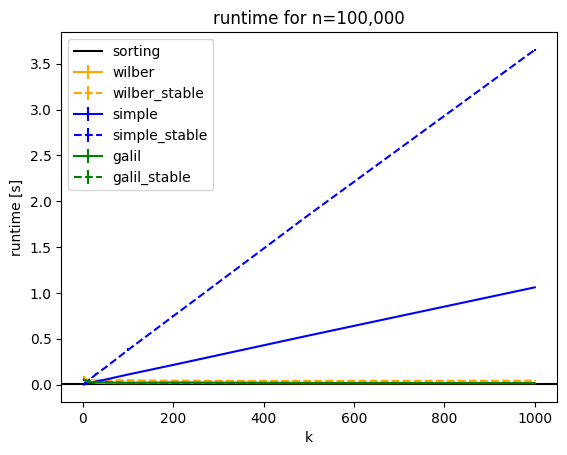

In [46]:
plot(df, 100_000, show_simple=True)

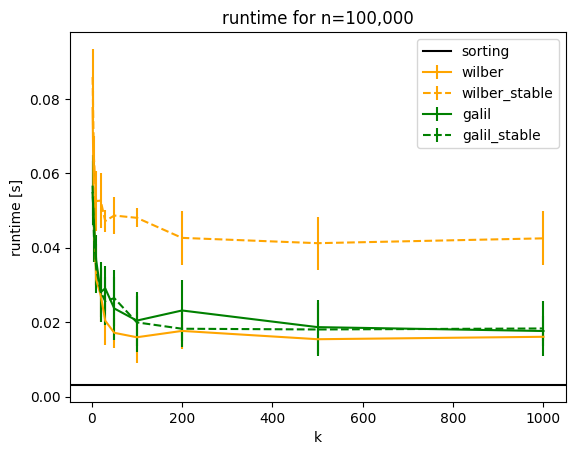

In [47]:
plot(df, 100_000, show_simple=False)

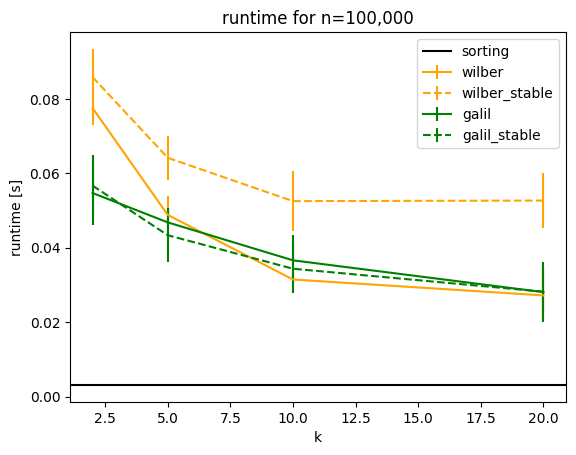

In [49]:
plot(df, 100_000, max_k=21, show_simple=False)

In [32]:
%%time
large_methods = {
    "wilber" : partial(wilber, stable=0),
    "galil_park": partial(_galil_park, stable=0),
    "wilber_stable" : partial(wilber, stable=1),
    "galil_park_stable": partial(_galil_park, stable=0),
}
records_large = execute([1_000_000], 10, large_methods)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 1min 42s
Wall time: 2min 19s


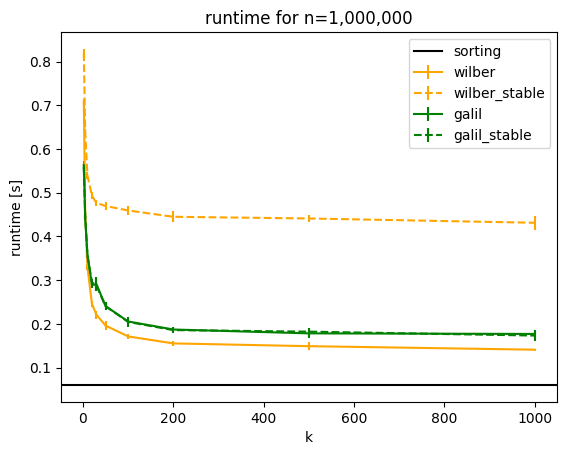

In [44]:
df_large = pd.DataFrame.from_records(records_large, columns=["name", "n", "k", "sample", "time"])
plot(df_large, 1_000_000)